In [426]:
# Student ID: 1006842543
# Student Name: Sheng Zhang
# Student Email: eily.zhang@mail.utoronto.ca
# Instructor: Professor Shion Guha
# Course Code: INF2178
# Course Name: Experimental Design for Data Science
# Program: MI
# Faculty of Information
# University of Toronto

In [427]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
%pip install bioinfokit
%pip install nhanes
%pip install pingouin
import pingouin as pg
from bioinfokit.analys import stat
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro, levene
from nhanes.load import load_NHANES_data
import statsmodels.stats.power as smp
from statsmodels.formula.api import mixedlm

# Display the original dataframe
df = pd.read_csv("INF2178_A4_data.csv")
df

,Unnamed: 0,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,366,OAS2_0184,OAS2_0184_MR2,Demented,2,553,F,R,73,16,3.0,21.0,1.0,1351,0.708,1.299
290,367,OAS2_0185,OAS2_0185_MR1,Demented,1,0,M,R,80,16,1.0,28.0,0.5,1704,0.711,1.030
291,368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
292,370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331


In [428]:
# Only keep the columns that we are interested in
columns_to_keep = ["Subject ID", "Group", "Visit", "eTIV", "nWBV", "ASF"]
data = df[columns_to_keep].copy()
data["Visit"] = data["Visit"].astype(str)
data["eTIV"] = data["eTIV"].astype(float)
# Extract the id for each Subject ID and convert it to type integer
data['id'] = data['Subject ID'].str.extract('(\d+)$').astype(int)
data = data[["id", "Group", "Visit", "eTIV", "nWBV", "ASF"]]
data

,id,Group,Visit,eTIV,nWBV,ASF
0,1,Nondemented,1,1987.0,0.696,0.883
1,1,Nondemented,2,2004.0,0.681,0.876
2,2,Demented,1,1678.0,0.736,1.046
3,2,Demented,2,1738.0,0.713,1.010
4,4,Nondemented,1,1215.0,0.710,1.444
...,...,...,...,...,...,...
289,184,Demented,2,1351.0,0.708,1.299
290,185,Demented,1,1704.0,0.711,1.030
291,185,Demented,2,1693.0,0.694,1.037
292,186,Nondemented,1,1319.0,0.801,1.331


In [429]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      294 non-null    int64  
 1   Group   294 non-null    object 
 2   Visit   294 non-null    object 
 3   eTIV    294 non-null    float64
 4   nWBV    294 non-null    float64
 5   ASF     294 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 13.9+ KB


**Exploratory Data Analysis**

In [430]:
# Create a summary table for the dataframe
data.describe()

,id,eTIV,nWBV,ASF
count,294.000000,294.000000,294.000000,294.000000
mean,93.081633,1478.853741,0.731381,1.203109
std,52.820581,176.559755,0.037373,0.139365
min,1.000000,1106.000000,0.646000,0.876000
25%,48.250000,1347.250000,0.703000,1.118250
50%,93.000000,1461.500000,0.732000,1.201000
75%,138.750000,1569.000000,0.756000,1.302750
max,186.000000,2004.000000,0.837000,1.587000


In [431]:
# Count the number of unique patients for each group
group_count = data.groupby("Group")["id"].nunique()
group_count

Group
Converted      14
Demented       64
Nondemented    72
Name: id, dtype: int64

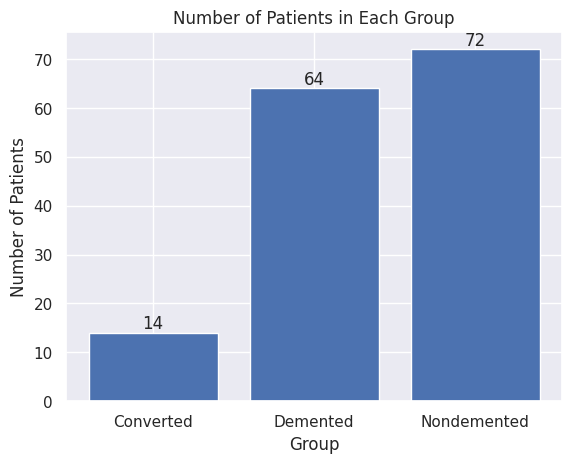

In [432]:
# Create bar graph for the number of patients in each group
plt.bar(group_count.index, group_count.values)

# Add labels for each bar
for i, count in enumerate(group_count.values):
    plt.text(i, count, str(count), ha="center", va="bottom")

plt.xlabel("Group")
plt.ylabel("Number of Patients")
plt.title("Number of Patients in Each Group")
plt.show()

In [433]:
# Count the number of patients by group and visit
grouped_data = data.groupby(["Group", "Visit"])["id"].nunique().reset_index()
grouped_data

,Group,Visit,id
0,Converted,1,14
1,Converted,2,12
2,Demented,1,64
3,Demented,2,62
4,Nondemented,1,72
5,Nondemented,2,70


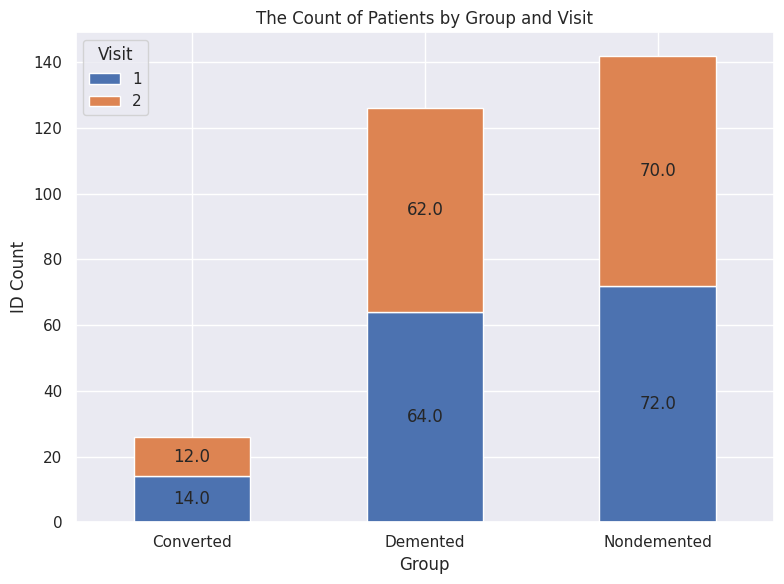

In [434]:
# Plot the bar graph for the number of patients for each combination of group and visit

# Pivot the DataFrame to have Group as columns and Visit as index
pivot_data = grouped_data.pivot(index="Group", columns="Visit", values="id")

# Plotting the stacked bar graph
ax = pivot_data.plot(kind="bar", stacked=True, figsize=(8, 6))

# Add labels for each part of the bar
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f"{height}", (x + width / 2, y + height / 2), ha="center", va="center")

plt.title("The Count of Patients by Group and Visit")
plt.xlabel("Group")
plt.ylabel("ID Count")
plt.xticks(rotation=0)
plt.legend(title="Visit")

plt.tight_layout()
plt.show()

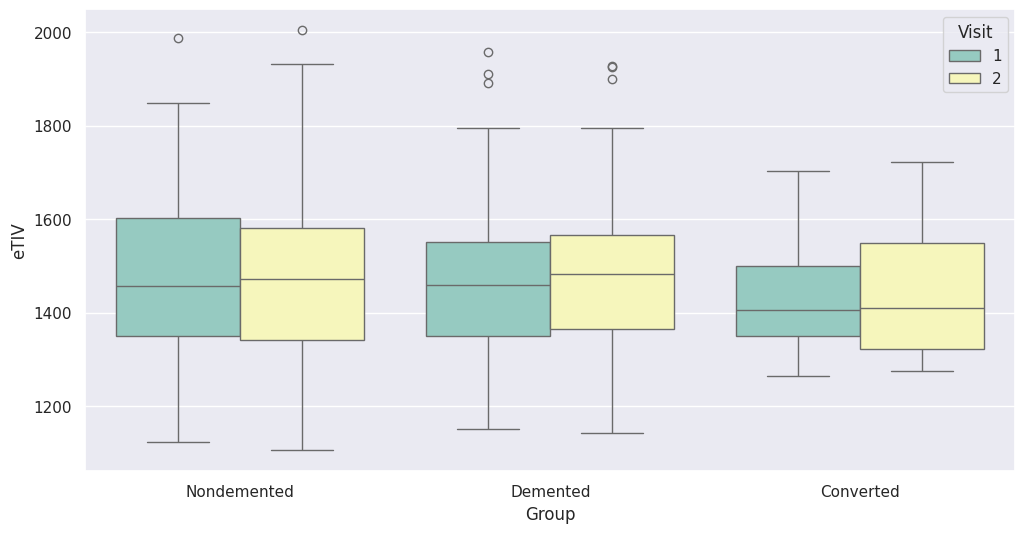

In [435]:
# Make the boxplot for eTIV(Estimated Total Intracranial Volume) between each Group AND each Visit
plt.figure(figsize=(12, 6))
sns.boxplot(x="Group", y="eTIV", hue="Visit", data=data, palette="Set3")
plt.xlabel("Group")
plt.ylabel("eTIV")
plt.show()

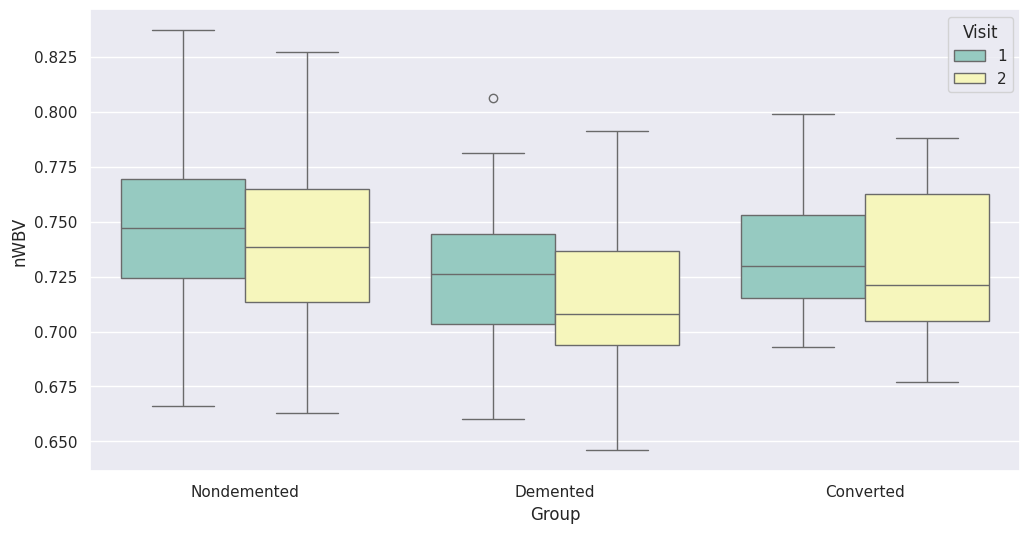

In [436]:
# Make the boxplot for nWBV(Normalize Whole Brain Volume) between each Group AND each Visit
plt.figure(figsize=(12, 6))
sns.boxplot(x="Group", y="nWBV", hue="Visit", data=data, palette="Set3")
plt.xlabel("Group")
plt.ylabel("nWBV")
plt.show()

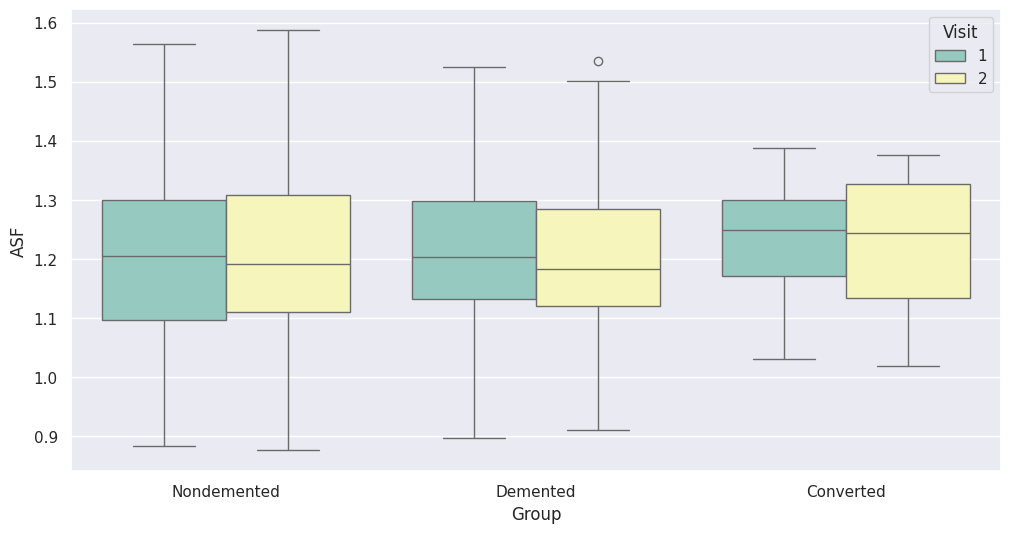

In [437]:
# Make the boxplot for ASF(Atlas Scaling Factor) between each Group AND each Visit
plt.figure(figsize=(12, 6))
sns.boxplot(x="Group", y="ASF", hue="Visit", data=data, palette="Set3")
plt.xlabel("Group")
plt.ylabel("ASF")
plt.show()

**Mixed-Effect ANOVA \
Dependent Variable: eTIV \
Between Subject Factor: Group \
Within Subject Factor: Visit**

<ipython-input-438-97c3665604ca>:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df, x="Group", y="eTIV", hue="Visit", dodge=True, markers=["o", "s"],


<Axes: xlabel='Group', ylabel='eTIV'>

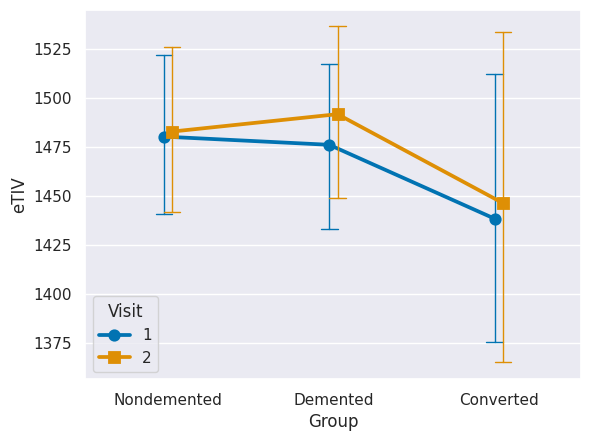

In [438]:
# Create the output plot for the two factors Group and Visit
sns.set()
sns.pointplot(data=df, x="Group", y="eTIV", hue="Visit", dodge=True, markers=["o", "s"],
	      capsize=.1, errwidth=1, palette="colorblind")

In [439]:
# Perform mixed-effect ANOVA
pg.mixed_anova(data=data, dv="eTIV", between="Group", within="Visit", subject="id")

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Group,37424.708356,2,141,18712.354178,0.297278,0.743302,0.004199,NaN
1,Visit,5573.920139,1,141,5573.920139,9.224900,0.002845,0.061407,1.0
2,Interaction,1004.783164,2,141,502.391582,0.831464,0.437535,0.011656,NaN


In [440]:
# Assumption 1: Spericity
pg.sphericity(data=data, dv="eTIV", within="Visit", subject="id")[-1]

1.0

In [441]:
# Assumption 2: Normality
data["factor_comb"] = data["Group"] + "-" + data["Visit"]
pg.normality(data, dv="eTIV", group = "factor_comb")

,W,pval,normal
factor_comb,,,
Nondemented-1,0.968937,0.071927,True
Nondemented-2,0.975840,0.194094,True
Demented-1,0.963033,0.052404,True
Demented-2,0.971023,0.149651,True
Converted-1,0.934993,0.357941,True
Converted-2,0.915798,0.252988,True


In [442]:
# Assumption 3: Homogeneity

# For first within group visit = 1
print(pg.homoscedasticity(data[data['Visit'] == "1"], dv="eTIV", group="Group"))

# For second within group visit = 2
print(pg.homoscedasticity(data[data['Visit'] == "2"], dv="eTIV", group="Group"))

               W      pval  equal_var
levene  0.942689  0.391921       True
               W      pval  equal_var
levene  0.405672  0.667304       True


**Mixed-Effect ANOVA \
Dependent Variable: nWBV \
Between Subject Factor: Group \
Within Subject Factor: Visit**

<ipython-input-443-673d59d49ec7>:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df, x="Group", y="nWBV", hue="Visit", dodge=True, markers=["o", "s"],


<Axes: xlabel='Group', ylabel='nWBV'>

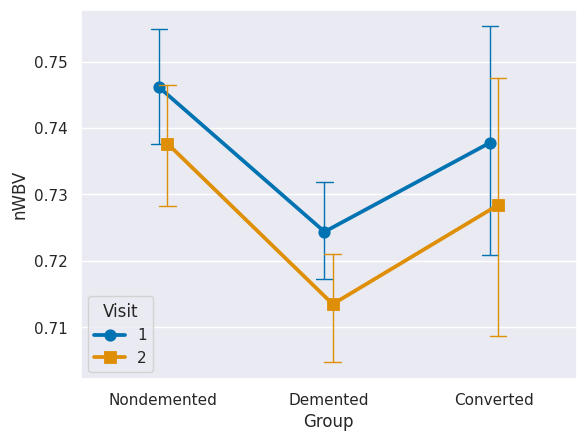

In [443]:
# Create the output plot for the two factors Group and Visit
sns.set()
sns.pointplot(data=df, x="Group", y="nWBV", hue="Visit", dodge=True, markers=["o", "s"],
	      capsize=.1, errwidth=1, palette="colorblind")

In [444]:
# Perform mixed-effect ANOVA
pg.mixed_anova(data=data, dv="nWBV", between="Group", within="Visit", subject="id")

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Group,0.033640,2,141,0.016820,6.712381,1.642113e-03,0.086934,NaN
1,Visit,0.006508,1,141,0.006508,94.251225,2.226896e-17,0.400641,1.0
2,Interaction,0.000212,2,141,0.000106,1.533508,2.193542e-01,0.021289,NaN


In [445]:
# Assumption 1: Spericity
pg.sphericity(data=data, dv="nWBV", within="Visit", subject="id")[-1]

1.0

In [446]:
# Assumption 2: Normality
pg.normality(data, dv="nWBV", group = "factor_comb")

,W,pval,normal
factor_comb,,,
Nondemented-1,0.988723,0.771999,True
Nondemented-2,0.983956,0.510883,True
Demented-1,0.992007,0.954626,True
Demented-2,0.979475,0.384691,True
Converted-1,0.933507,0.341468,True
Converted-2,0.940329,0.502351,True


In [447]:
# Assumption 3: Homogeneity

# For first within group visit = 1
print(pg.homoscedasticity(data[data['Visit'] == "1"], dv="nWBV", group="Group"))

# For second within group visit = 2
print(pg.homoscedasticity(data[data['Visit'] == "2"], dv="nWBV", group="Group"))

               W     pval  equal_var
levene  1.045199  0.35422       True
               W      pval  equal_var
levene  0.298582  0.742338       True


**Mixed-Effect ANOVA \
Dependent Variable: ASF \
Between Subject Factor: Group \
Within Subject Factor: Visit**

<ipython-input-448-ed37e22784c5>:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df, x="Group", y="ASF", hue="Visit", dodge=True, markers=["o", "s"],


<Axes: xlabel='Group', ylabel='ASF'>

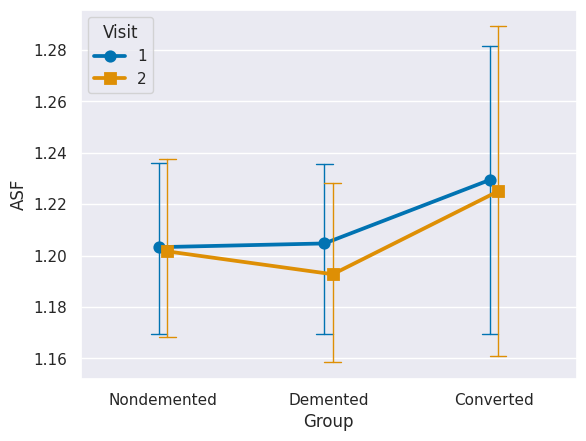

In [448]:
# Create the output plot for the two factors Group and Visit
sns.set()
sns.pointplot(data=df, x="Group", y="ASF", hue="Visit", dodge=True, markers=["o", "s"],
	      capsize=.1, errwidth=1, palette="colorblind")

In [449]:
# Perform mixed-effect ANOVA
pg.mixed_anova(data=data, dv="ASF", between="Group", within="Visit", subject="id")

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Group,0.018402,2,141,0.009201,0.233695,0.791909,0.003304,NaN
1,Visit,0.003160,1,141,0.003160,8.754326,0.003624,0.058458,1.0
2,Interaction,0.000742,2,141,0.000371,1.027595,0.360531,0.014366,NaN


In [450]:
# Assumption 1: Spericity
pg.sphericity(data=data, dv="ASF", within="Visit", subject="id")[-1]

1.0

In [451]:
# Assumption 2: Normality
pg.normality(data, dv="ASF", group = "factor_comb")

,W,pval,normal
factor_comb,,,
Nondemented-1,0.989508,0.816622,True
Nondemented-2,0.992769,0.960823,True
Demented-1,0.986235,0.696870,True
Demented-2,0.982480,0.519384,True
Converted-1,0.957046,0.674286,True
Converted-2,0.932284,0.404957,True


In [452]:
# Assumption 3: Homogeneity

# For first within group visit = 1
print(pg.homoscedasticity(data[data['Visit'] == "1"], dv="ASF", group="Group"))

# For second within group visit = 2
print(pg.homoscedasticity(data[data['Visit'] == "2"], dv="ASF", group="Group"))

               W      pval  equal_var
levene  0.879076  0.417337       True
               W     pval  equal_var
levene  0.391774  0.67659       True


**Compute Sample Size by Using the Statistical Power Analysis**

In [453]:
# Compute the sample size with the given power, alpha level, and effect size
power_analysis = smp.TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=0.7, power=0.91, alpha=0.05)
sample_size

45.45073088568012